In this homework, we will use the New York City Airbnb Open Data. You can take it from
[Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

The goal of this homework is to create a regression model for prediction apartment prices (column `'price'`).

In [402]:
# Import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [403]:
data = 'nyc_airbnb_data/AB_NYC_2019.csv'
# making the data readable consistently
df = pd.read_csv(data)
df.columns = df.columns.str.lower().str.replace(' ','_') 
strings = list(df.dtypes[df.dtypes == 'object'].index)

for col in strings:
    df[col] = df[col].str.lower().str.replace(' ','_') 
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,clean_&_quiet_apt_home_by_the_park,2787,john,brooklyn,kensington,40.64749,-73.97237,private_room,149,1,9,2018-10-19,0.21,6,365
1,2595,skylit_midtown_castle,2845,jennifer,manhattan,midtown,40.75362,-73.98377,entire_home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,the_village_of_harlem....new_york_!,4632,elisabeth,manhattan,harlem,40.80902,-73.94190,private_room,150,3,0,NaN,NaN,1,365
3,3831,cozy_entire_floor_of_brownstone,4869,lisaroxanne,brooklyn,clinton_hill,40.68514,-73.95976,entire_home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,entire_apt:_spacious_studio/loft_by_central_park,7192,laura,manhattan,east_harlem,40.79851,-73.94399,entire_home/apt,80,10,9,2018-11-19,0.10,1,0


In [404]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [405]:
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

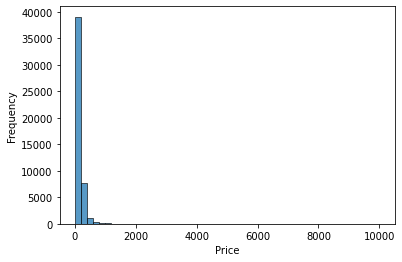

In [406]:
sns.histplot(df['price'],bins = 50)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()
plt.close()

There is a large tail and the data is skewed right

### EDA

* Load the data.
* Look at the `price` variable. Does it have a long tail? 

### Features

For the rest of the homework, you'll need to use only these columns:

* `'latitude'`,
* `'longitude'`,
* `'price'`,
* `'minimum_nights'`,
* `'number_of_reviews'`,
* `'reviews_per_month'`,
* `'calculated_host_listings_count'`,
* `'availability_365'`


In [407]:
check = ['latitude',
'longitude',
'price',
'minimum_nights',
'number_of_reviews',
'reviews_per_month',
'calculated_host_listings_count',
'availability_365']
df = df[check]

In [408]:
df[check].isna().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

## Question 1

Find a feature with missing values. How many missing values does it have?

reviews_per_month is the only column with NA/null values

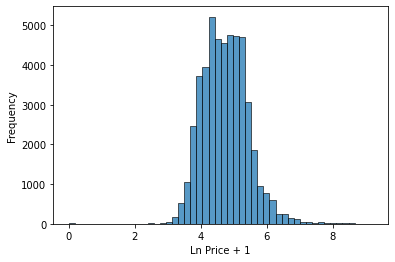

In [241]:
sns.histplot(np.log1p(df['price']),bins = 50)
plt.xlabel('Ln Price + 1')
plt.ylabel('Frequency')
plt.show()

Log(price) + 1 histogram is normally distributed

## Question 2

What's the median (50% percentile) for variable 'minimum_nights'?

In [242]:
min_nights_med = df['minimum_nights'].median()
print('Median of minumum nights series is', str(int(min_nights_med)))

Median of minumum nights series is 3


### Split the data

* Shuffle the initial dataset, use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Make sure that the target value ('price') is not in your dataframe.
* Apply the log transformation to the price variable using the `np.log1p()` function.

In [273]:
def shuffle_df(df,seed,check,remove):
    np.random.seed(seed)

    n = len(df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    df_train = df_train.reset_index(drop = True)
    df_val = df_val.reset_index(drop = True)
    df_test = df_test.reset_index(drop = True)
    
    y_train_orig = df_train[remove].values
    y_val_orig = df_val[remove].values
    y_test_orig = df_test[remove].values

    y_train = np.log1p(df_train[remove].values)
    y_val = np.log1p(df_val[remove].values)
    y_test = np.log1p(df_test[remove].values)

    del df_train[remove]
    del df_val[remove]
    del df_test[remove]
    
    if(remove in check):
        check.remove(remove)

    
    return df_train,df_val,df_test,y_train,y_val,y_test

In [369]:
df_train,df_val,df_test,y_train,y_val,y_test = shuffle_df(df,1,check,'price')

array([4.02535169, 5.0689042 , 4.79579055, ..., 4.33073334, 3.91202301,
       4.61512052])

In [275]:
check

['latitude',
 'longitude',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?


In [276]:
df_train.isna().sum()

latitude                             0
longitude                            0
minimum_nights                       0
number_of_reviews                    0
reviews_per_month                 6031
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [277]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [278]:
def rmse(y,y_pred):
    diff = y-y_pred
    diff_squared = diff**2
    mse = diff_squared.mean()
    return mse

In [279]:
def prepare_X(df,fill_val):
    df_num = df[check]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [280]:
def calc_y_pred_values(df,y,fill,r):
    X = prepare_X(df,fill)
    if r == 1:
        w = train_linear_regression(X,y)
    else:
        w =  train_linear_regression_reg(X,y,r)
    return w[0] + X.dot(w[1])

In [383]:
y_pred = (calc_y_pred_values(df_train,y_train,df_train['reviews_per_month'].mean(),1))
print('train_mean RMSE:',round(rmse(y_train,y_pred),2))

y_pred = (calc_y_pred_values(df_val,y_val,df_val['reviews_per_month'].mean(),1))
print('val_mean RMSE:',round(rmse(y_val,y_pred),2))

train_mean RMSE: 0.41
val_mean RMSE: 0.42


In [384]:
y_pred = (calc_y_pred_values(df_train,y_train,0,1))
print('train_zero RMSE:',round(rmse(y_train,y_pred),2))

y_pred = (calc_y_pred_values(df_val,y_val,0,1))
print('val_zero RMSE:',round(rmse(y_val,y_pred),2))

train_zero RMSE: 0.41
val_zero RMSE: 0.42


Both zero and average filling of the missing values presented the same value -- either fill can be used

### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

In [283]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [284]:
r = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

In [285]:
def best_r_val(r_list):
    for r in r_list:
        w_value = train_linear_regression_reg(zero_train_X,y_train,r)
        rmse_value = rmse(w_value[0] + X_val_zero.dot(w_value[1]),y_val)
        print('r:',"{:e}".format(r),'\tw0:',"{:e}".format(w_value[0]),'\t\trmse:', round(rmse_value,5))

In [286]:
best_r_val(r)

r: 0.000000e+00 	w0: -4.147055e+02 		rmse: 0.41764
r: 1.000000e-06 	w0: -4.146568e+02 		rmse: 0.41764
r: 1.000000e-04 	w0: -4.098848e+02 		rmse: 0.41772
r: 1.000000e-03 	w0: -3.710641e+02 		rmse: 0.41878
r: 1.000000e-02 	w0: -1.905711e+02 		rmse: 0.43479
r: 1.000000e-01 	w0: -3.249627e+01 		rmse: 0.46377
r: 1.000000e+00 	w0: -3.494924e+00 		rmse: 0.4706
r: 5.000000e+00 	w0: -7.026202e-01 		rmse: 0.4713
r: 1.000000e+01 	w0: -3.509476e-01 		rmse: 0.47141


The best r value is 0

### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

In [390]:
def zero_fill_collect(df,seed,check,remove,r,df_use):
    df_train,df_val,df_test,y_train,y_val,y_test = shuffle_df(df,seed,check,remove)
    if df_use == 'val':
        y_pred = (calc_y_pred_values(df_val,y_val,0,r))
        rmse_val = round(rmse(y_val,y_pred),4)
    if df_use == 'test':
        df_train_val = pd.concat([df_train,df_val])
        df_train_val = df_train_val.reset_index(drop = True)

        y_train_val = pd.DataFrame(np.array(list(y_train) + list(y_val)))
        
        y_pred = (calc_y_pred_values(df_train_val,y_train_val,0,r))
        rmse_val = round(rmse(y_test,y_pred),4)
    return rmse_val,[df_train,df_val,df_test],[y_train,y_val,y_test]

In [389]:
rmse_list = []
seed_values = [x for x in range(0,1000)]

for x in seed_values:
    rmse_val, df_triad, y_triad = zero_fill_collect(df,x,check,'price',1,'val')
    rmse_list.append(rmse_val)

rmse_array = np.array(rmse_list)
rounded_std = round(np.std(rmse_array),3)
print(rounded_std)

0.008


### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
r = 0.001* What's the RMSE on the test dataset?

In [409]:
r = 0.001
for seed in range(0,10):
    rmse_val, df_triad, y_triad = zero_fill_collect(df,seed,check,'price',r,'test')
    print(x,rmse_val)

0 0.5255
1 0.5505
2 0.5414
3 0.5367
4 0.5586
5 0.5332
6 0.5453
7 0.5565
8 0.5344
9 0.5454


RMSE for Seed:9 with regularization of 0.001 is 0.5454